In [10]:
def plot_column(dataframe,colonna):
	plt.plot(dataframe[colonna])
	plt.title(colonna)
	plt.show()

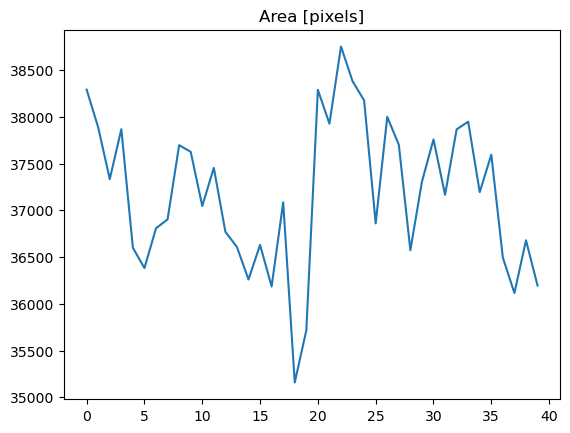

In [11]:
plot_column(df_new_parts,'Area [pixels]')